In [3]:
!pip install -qqq easy-vqa tensorflow Pillow numpy

In [4]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers

In [5]:
def setup():
    print('\n--- Reading questions...')
    train_qs, train_answers, train_image_ids = get_train_questions()
    test_qs, test_answers, test_image_ids = get_test_questions()
    print(f'Read {len(train_qs)} training questions and {len(test_qs)} testing questions.')

    print('\n--- Reading answers...')
    all_answers = get_answers()
    num_answers = len(all_answers)
    print(f'Found {num_answers} total answers:')
    print(all_answers)

    print('\n--- Reading/processing images...')
    def load_and_process_image(image_path):
        # Load image, then scale and shift pixel values to [-0.5, 0.5]
        im = img_to_array(load_img(image_path))
        return im / 255 - 0.5

    def read_images(paths):
        ims = {}
        for image_id, image_path in paths.items():
            ims[image_id] = load_and_process_image(image_path)
        return ims

    train_ims = read_images(get_train_image_paths())
    test_ims = read_images(get_test_image_paths())
    im_shape = train_ims[0].shape
    print(f'Read {len(train_ims)} training images and {len(test_ims)} testing images.')
    print(f'Each image has shape {im_shape}.')

    print('\n--- Fitting question tokenizer...')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_qs)

    vocab_size = len(tokenizer.word_index) + 1
    print(f'Vocab Size: {vocab_size}')
    print(tokenizer.word_index)

    print('\n--- Converting questions to bags of words...')
    train_X_seqs = tokenizer.texts_to_matrix(train_qs)
    test_X_seqs = tokenizer.texts_to_matrix(test_qs)
    print(f'Example question bag of words: {train_X_seqs[0]}')

    print('\n--- Creating model input images...')
    train_X_ims = np.array([train_ims[id] for id in train_image_ids])
    test_X_ims = np.array([test_ims[id] for id in test_image_ids])

    print('\n--- Creating model outputs...')
    train_answer_indices = [all_answers.index(a) for a in train_answers]
    test_answer_indices = [all_answers.index(a) for a in test_answers]
    train_Y = to_categorical(train_answer_indices)
    test_Y = to_categorical(test_answer_indices)
    print(f'Example model output: {train_Y[0]}')

    return (train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs,
            test_Y, im_shape, vocab_size, num_answers,
            all_answers, test_qs, test_answer_indices)


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply
from tensorflow.keras.optimizers import Adam

def build_model(im_shape, vocab_size, num_answers, big_model=False):
    # The CNN
    im_input = Input(shape=im_shape)
    x1 = Conv2D(8, 3, padding='same')(im_input)
    x1 = MaxPooling2D()(x1)
    x1 = Conv2D(16, 3, padding='same')(x1)
    x1 = MaxPooling2D()(x1)
    if big_model:
        x1 = Conv2D(32, 3, padding='same')(x1)
        x1 = MaxPooling2D()(x1)
    x1 = Flatten()(x1)
    x1 = Dense(32, activation='tanh')(x1)

    # The question network
    q_input = Input(shape=(vocab_size,))
    x2 = Dense(32, activation='tanh')(q_input)
    x2 = Dense(32, activation='tanh')(x2)

    # Merge -> output
    out = Multiply()([x1, x2])
    out = Dense(32, activation='tanh')(out)
    out = Dense(num_answers, activation='softmax')(out)

    model = Model(inputs=[im_input, q_input], outputs=out)
    model.compile(Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
big_model = True

(train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs, test_Y,
 im_shape, vocab_size, num_answers, all_answers, test_qs, test_answer_indices
 ) = setup()

print('\n--- Building model...')
model = build_model(im_shape, vocab_size, num_answers, big_model)
checkpoint = ModelCheckpoint('model.keras', save_best_only=True)


print('\n--- Training model...')
history = model.fit(
       [train_X_ims, train_X_seqs],
       train_Y,
       validation_data=([test_X_ims, test_X_seqs], test_Y),
       shuffle=True,
       epochs=12,
       callbacks=[checkpoint],
   )



--- Reading questions...
Read 38575 training questions and 9673 testing questions.

--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']

--- Reading/processing images...
Read 4000 training images and 1000 testing images.
Each image has shape (64, 64, 3).

--- Fitting question tokenizer...
Vocab Size: 27
{'is': 1, 'shape': 2, 'the': 3, 'a': 4, 'image': 5, 'there': 6, 'not': 7, 'what': 8, 'present': 9, 'does': 10, 'contain': 11, 'in': 12, 'color': 13, 'no': 14, 'circle': 15, 'rectangle': 16, 'triangle': 17, 'brown': 18, 'yellow': 19, 'gray': 20, 'teal': 21, 'black': 22, 'red': 23, 'green': 24, 'blue': 25, 'of': 26}

--- Converting questions to bags of words...
Example question bag of words: [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]

--- Creating model input images...

--- Creating model outputs...
Example model output: [0. 0. 0. 0. 0. 

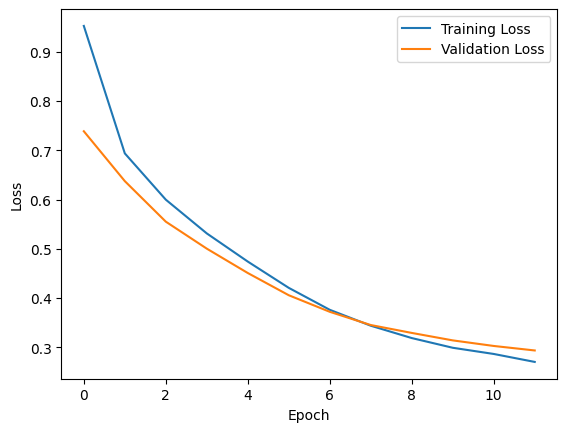

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Predictions and error analysis
predictions = model.predict([test_X_ims, test_X_seqs])

for idx in range(num_answers):
    pred_values = predictions[:, idx]
    answer = all_answers[idx]
    print(f'\nStatistics for answer {idx}, {answer}')
    min_val = np.amin(pred_values)
    max_val = np.amax(pred_values)
    mean_val = np.mean(pred_values)
    print(f'Min: {min_val}, Max: {max_val}, Mean: {mean_val}')

shapes = []
yesno = []
for i in range(num_answers):
    if (all_answers[i] == 'rectangle' or all_answers[i] == 'circle' or all_answers[i] == 'triangle'):
        shapes.append(i)
    elif all_answers[i] == 'yes' or all_answers[i] == 'no':
        yesno.append(i)

def return_class(answer):
    if answer in shapes:
        return 0
    if answer in yesno:
        return 1
    return 2

error_matrix = [[0 for _ in range(3)] for _ in range(3)]
total_errors = 0



303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step

Statistics for answer 0, circle
Min: 6.407580031009275e-07, Max: 0.7056384682655334, Mean: 0.04403254762291908

Statistics for answer 1, green
Min: 3.9985800981412467e-07, Max: 0.9977707266807556, Mean: 0.017554674297571182

Statistics for answer 2, red
Min: 2.5331226538582996e-07, Max: 0.9971308708190918, Mean: 0.01594706065952778

Statistics for answer 3, gray
Min: 8.971660747647547e-08, Max: 0.9918312430381775, Mean: 0.02006535604596138

Statistics for answer 4, yes
Min: 4.131415494157409e-07, Max: 0.9996820688247681, Mean: 0.37724927067756653

Statistics for answer 5, teal
Min: 1.049104358941122e-08, Max: 0.9930619597434998, Mean: 0.015484990552067757

Statistics for answer 6, black
Min: 1.3076419236313086e-07, Max: 0.9955019354820251, Mean: 0.01528855599462986

Statistics for answer 7, rectangle
Min: 1.2657224033318926e-06, Max: 0.8434981107711792, Mean: 0.050347700715065

Statistics for answer 8, yellow
Min: 1.7669830043587353e-08, Max: 

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_answer_indices

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
print(f"Macro F1 Score: {macro_f1}")

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8610565491574486
Macro F1 Score: 0.8485528784886338
Confusion Matrix:
[[  96    0    0    0    0    0    0  204    0  116    0    0    0]
 [   0  165    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0  151    0    0    0    0    0    0    0    5    0    0]
 [   0    0    0  174    0    1    3    0    0    0    0    0    0]
 [   0    0    0    0 3259    0    0    0    0    0    0    0  352]
 [   0    2    0    0    0  147    0    0    0    0    0    0    0]
 [   0    0    0   16    0    0  139    0    0    0    1    0    0]
 [ 111    0    0    0    0    0    0  288    0   51    0    0    0]
 [   0    3    2    0    0    0    1    0  163    0    0    0    0]
 [  31    0    0    0    0    0    0   93    0  267    0    0    0]
 [   0    0    0    0    0    0    4    0    0    0  150    0    0]
 [   0    0    0    4    0    2    0    0    0    0    0  147    0]
 [   0    0    0    0  342    0    0    0    0    0    0    0 3183]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


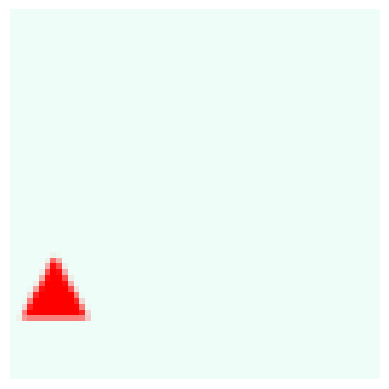

Question: what is the red shape?
True Answer: triangle
Predicted Answer: triangle


In [13]:
index = 0

image = test_X_ims[index]
question = test_X_seqs[index]
true_answer = all_answers[test_answer_indices[index]]

image = image.reshape(1, *im_shape)

prediction = model.predict([image, question.reshape(1, -1)])

predicted_answer_index = np.argmax(prediction)
predicted_answer = all_answers[predicted_answer_index]

plt.imshow(image[0] + 0.5)  # Add 0.5 to shift pixel values back to [0, 1]
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

print(f"Question: {test_qs[index]}")
print(f"True Answer: {true_answer}")
print(f"Predicted Answer: {predicted_answer}")